# Spectrogram generation tests

Checking how spectrogram generation is affected by parameters and audio sampling frequency

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.io.wavfile

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency, audio_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in the metadata to pandas

In [2]:
base_path = '/media/michael/Seagate/urban8k/'
meta_path = base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv'
wav_path = base_path + 'UrbanSound8K/resampled_audio/'

In [3]:
# load a file of all the data about the dataset
data = pd.read_csv(meta_path)

# getting the paths to an example from each class...
class_to_path = {}
for i in data.index:
    if data['class'][i] not in class_to_path:
        folder = 'fold' + str(data['fold'][i]) + '/'
        class_to_path[data['class'][i]] = folder + data['slice_file_name'][i]
        

## Assessing the effect of resampling the audio

Note that I don't just resample the signal, I also make sure the sampling rate is updated.

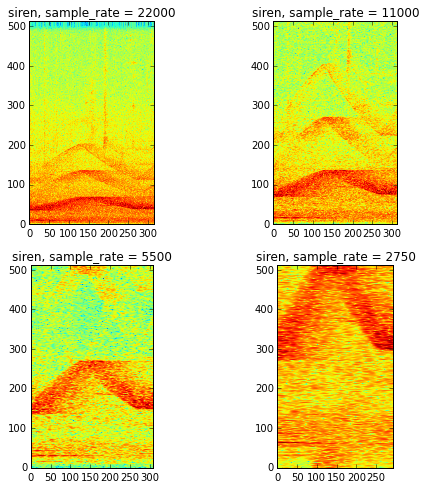

In [4]:
spectrogram_parameters = {
    'nfft': 1024,
    'spec_sample_rate': 80
    }

def plot_spec(spec):
    plt.imshow(spec)
    plt.gca().invert_yaxis()

key = 'siren'

# loading in the siren data
sample_rate, wav = scipy.io.wavfile.read(wav_path + class_to_path[key])

# doing spectrogram of original data
spec = frequency.spectrogram(wav[:, 0].ravel(), sample_rate, **spectrogram_parameters)

plt.figure(figsize=(8, 8))

for count in range(4):

    plt.subplot(2, 2, count+1)
    plot_spec(spec)
    plt.title(key + ', sample_rate = ' + str(sample_rate))

    # now downsampling the audio and recomputing the spectrogram
    wav = wav[::2]
    sample_rate /= 2

    spec = frequency.spectrogram(wav[:, 0].ravel(), sample_rate, **spectrogram_parameters)

So the sampling rate does make a difference!

Now let's try some other stuff...

## Changing the number of frequency bins

**This is in fact the same as the window width**! 

The width of the window (in samples) ends up being twice the number of frequency bins!

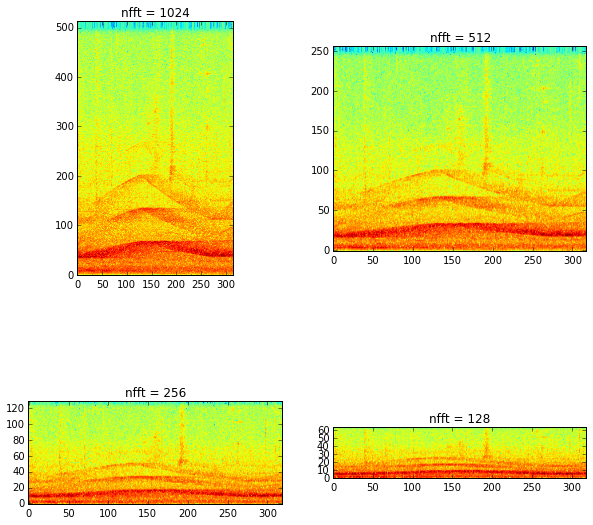

In [5]:
# loading in the siren data
sample_rate, wav = scipy.io.wavfile.read(wav_path + class_to_path[key])

# doing spectrogram for different nfft values
plt.figure(figsize=(10, 10))

for count, nfft in enumerate([1024, 512, 256, 128]):
    spec = frequency.spectrogram(wav[:, 0].ravel(), sample_rate, 
                                 nfft=nfft, spec_sample_rate=80)

    
    plt.subplot(2, 2, count+1)
    plot_spec(spec)
    plt.title('nfft = ' + str(nfft))

## Changing the *spectrogram* sample rate

This effectively changes the overlap between adjacient windows, however I changed the code to be adjusted in terms of the spectrogram sample rate, i.e. how many windows to sample per second of audio. This makes more logical sense to me!

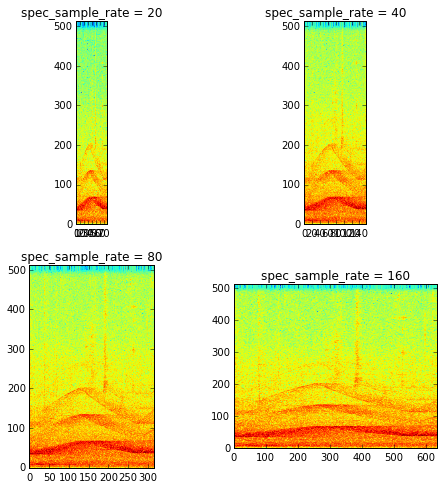

In [13]:
# loading in the siren data
sample_rate, wav = scipy.io.wavfile.read(wav_path + class_to_path[key])

# doing spectrogram for different nfft values
plt.figure(figsize=(8, 8))

for count, spec_sample_rate in enumerate([20, 40, 80, 160]):
    spec = frequency.spectrogram(wav[:, 0].ravel(), sample_rate, 
                                 nfft=1024, spec_sample_rate=spec_sample_rate)

    
    plt.subplot(2, 2, count+1)
    plot_spec(spec)
    plt.title('spec_sample_rate = ' + str(spec_sample_rate))

# Visualising different normalisation strategies

How should we normalise the spectrograms?

There are lots of different options. Below, we show the results of some different strategies on a selection of 15 spectrograms.

I can write up how these strategies work if that's useful.

I'm currently running code to see which normalisation strategy provides the best results...

[1289 7293 1344 7291 4829 1520 6400 5648 4452  239 2443 2102 3416 7290  574]


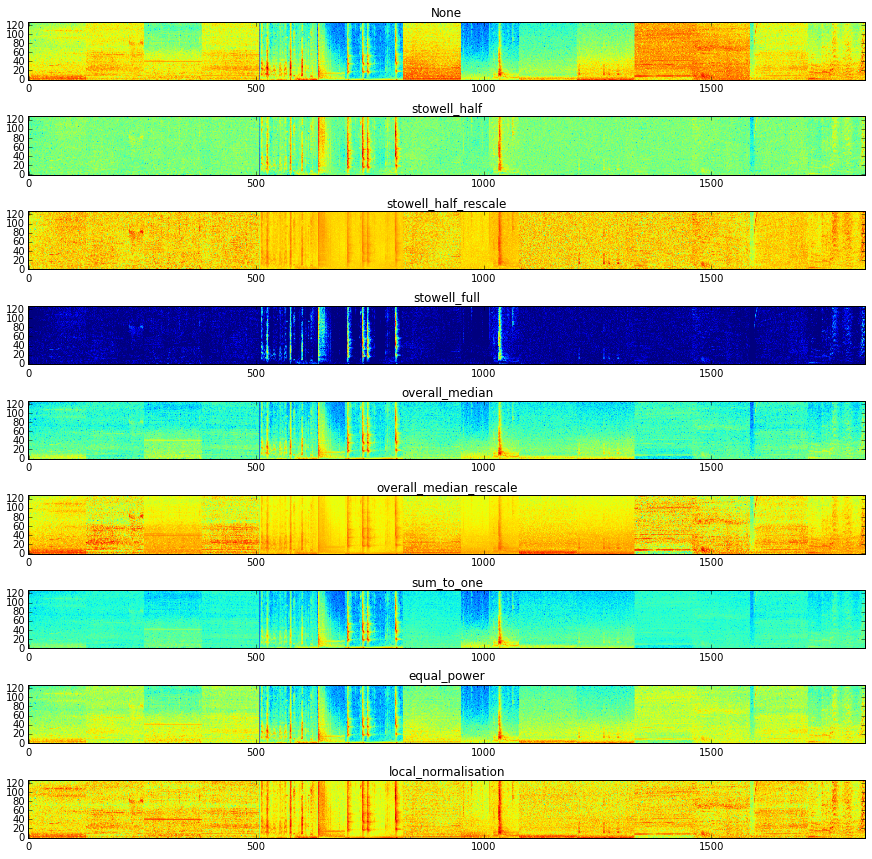

In [53]:
# testing some normalisation strategies...
strategies = [None, 'stowell_half', 'stowell_half_rescale', 'stowell_full', 
              'overall_median', 'overall_median_rescale', 'sum_to_one', 
              'equal_power', 'local_normalisation']

plt.figure(figsize=(15, 15))

np.random.seed(10)
idxs = np.random.randint(0, len(data), 15)
print idxs
for count, normalisation_strategy in enumerate(strategies):

    specs = []
    for idx in idxs:
        folder = 'fold' + str(data['fold'][idx]) + '/'
        wav_file = folder + data['slice_file_name'][idx]
        
        # loading in wav
        sample_rate, wav = scipy.io.wavfile.read(wav_path + wav_file)
        try:
            spec = frequency.spectrogram(wav[:, 0].ravel(), sample_rate, 
                                     nfft=512, spec_sample_rate=32)[:128, :]
        except:
            print wav.shape
        if normalisation_strategy is not None:
            spec = audio_utils.normalise(spec, normalisation_strategy)
            
        specs.append(spec)
        
    plt.subplot(len(strategies), 1, count+1)
    plot_spec(np.hstack(specs))
    plt.title(normalisation_strategy)
    